In [36]:
import torch
import numpy as np
import random
import math
from torch import nn,tensor
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchmetrics.classification import MulticlassAccuracy 
import torchvision.transforms.functional as TF

import fastcore.all as fc

from lib import *

def set_seed(seed):
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    
@inplace
def transformi(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]
    

class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn):
        raise CancelFitException
        
        
def print_obj_API(obj):
    attributes = [attr for attr in dir(obj) if not attr.startswith('__')]

    # Differentiating between methods and attributes
    methods = [attr for attr in attributes if callable(getattr(obj, attr)) and not attr.startswith('_')]
    attributes = [attr for attr in attributes if not callable(getattr(obj, attr)) and not attr.startswith('_')]
    
    print(f"{type(obj).__name__} Attributes:", attributes)
    print("\n")
    print(f"{type(obj).__name__} Methods:", methods)

def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: # add bias if norm is not a BatchNormLayer
        bias = not isinstance(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: 
        layers.append(norm(nf))
    if act: 
        layers.append(act())
    return nn.Sequential(*layers)

def get_model(act=nn.ReLU, nfs=None, norm=None):
    # nfs layer dims chain
    if nfs is None:
        nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, 
                         conv(nfs[-1], 10, act=None, norm=False, bias = True),
                         nn.Flatten()).to(device)             

device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
set_seed(42)
metrics = MetricCB(MulticlassAccuracy(10))

x,y = 'image','label'
dsd = load_dataset("fashion_mnist")
bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_datasetDict(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

xmean, xstd = xb.mean(), xb.std()
xmean, xstd # no normally distributed!

def normalize(b):
    return (b[0]-xmean)/xstd, b[1]

norm = BatchTransformCB(normalize) 

leak = 0.1
general_leaky_relu = partial(GeneralRelu, leak=leak, subtract=0.4)
astats = ActivationStats(append_stats, fc.risinstance(GeneralRelu)) # get only GeneralRelu # ,
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats, norm] 
f_init_weights = partial(init_weights, leaky=leak)

In [37]:
# get optimizer by instanciating the learner using pyt.optim.sgd
model = get_model(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=[SingleBatchCB()])
learn.fit(1)

In [38]:
optimizer = learn.opt # fit model for 1 batch s.t. just to get its opt 
print_obj_API(optimizer)

SGD Attributes: ['defaults', 'param_groups', 'state']


SGD Methods: ['OptimizerPostHook', 'OptimizerPreHook', 'add_param_group', 'load_state_dict', 'profile_hook_step', 'register_load_state_dict_post_hook', 'register_load_state_dict_pre_hook', 'register_state_dict_post_hook', 'register_state_dict_pre_hook', 'register_step_post_hook', 'register_step_pre_hook', 'state_dict', 'step', 'zero_grad']


In [39]:
# let's visualize the annealing of the lr
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    print("last 5 lrs: ", lrs[-5:])
    plt.plot(lrs)
    
# The call to sched.optimizer.step() is "required" because
# you should call `optimizer.step()` before `lr_scheduler.step()`.  
# Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.

In [40]:
from torch.optim.lr_scheduler import CosineAnnealingLR
sched = CosineAnnealingLR(optimizer, 100)

last 5 lrs:  [[2.6569123906967083e-05], [3.612485709187885e-05], [4.712525830705322e-05], [5.955947148458523e-05], [7.341522555726953e-05]]


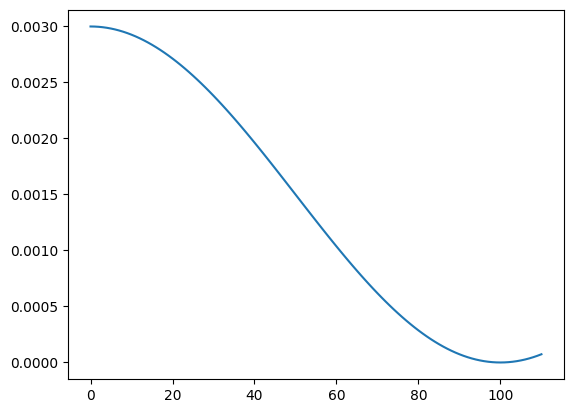

In [41]:
sched_lrs(sched, 110) # goes up after 100 steps cuz cosine curve

In [42]:
print_obj_API(sched)

CosineAnnealingLR Attributes: ['T_max', 'base_lrs', 'eta_min', 'last_epoch', 'optimizer', 'verbose']


CosineAnnealingLR Methods: ['get_last_lr', 'get_lr', 'load_state_dict', 'print_lr', 'state_dict', 'step']


In [43]:
sched.T_max

100

In [44]:
sched.state_dict()["_step_count"]

111

In [45]:
sched.state_dict()

{'T_max': 100,
 'eta_min': 0,
 'base_lrs': [0.003],
 'last_epoch': 110,
 'verbose': False,
 '_step_count': 111,
 '_get_lr_called_within_step': False,
 '_last_lr': [7.341522555726953e-05]}

In [50]:
from torch.optim.lr_scheduler import OneCycleLR
sched = OneCycleLR(optimizer, max_lr =0.5, total_steps=100)

In [51]:
print_obj_API(sched)

OneCycleLR Attributes: ['base_lrs', 'cycle_momentum', 'last_epoch', 'optimizer', 'total_steps', 'use_beta1', 'verbose']


OneCycleLR Methods: ['anneal_func', 'get_last_lr', 'get_lr', 'load_state_dict', 'print_lr', 'state_dict', 'step']


In [52]:
sched.state_dict()

{'total_steps': 100,
 '_schedule_phases': [{'end_step': 29.0,
   'start_lr': 'initial_lr',
   'end_lr': 'max_lr',
   'start_momentum': 'max_momentum',
   'end_momentum': 'base_momentum'},
  {'end_step': 99,
   'start_lr': 'max_lr',
   'end_lr': 'min_lr',
   'start_momentum': 'base_momentum',
   'end_momentum': 'max_momentum'}],
 'anneal_func': <function torch.optim.lr_scheduler.OneCycleLR._annealing_cos(start, end, pct)>,
 'cycle_momentum': True,
 'use_beta1': False,
 'base_lrs': [0.02],
 'last_epoch': 0,
 'verbose': False,
 '_step_count': 1,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.020000000000000018]}

In [ ]:
class BaseSchedCB(Callback):
    '''
    scheduler: partial with ctor of the desired scheduler with T_max
    
    eg: BaseSchedCB(partial(CosineAnnealingLR, T_max=val))
    
    the scheduler is an handler of the optimizer
    the optimizer is agnostic of the scheduler
    '''
    
    def __init__(self, scheduler):
        self.scheduler = scheduler
        
    def before_fit(self, learn):
        # before fit sets gets learner optimizers and uses it to call ctor of scheduler
        self.scheduler_optimizer = self.scheduler(learn.opt)
    
    def step(self, learn):
        if learn.training and self.scheduler_optimizer.T_max <= self.scheduler_optimizer.state_dict()["_step_count"]: 
            self.scheduler_optimizer.step()

In [16]:
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self.step(learn)

In [17]:
n_epochs = 3
tmax = n_epochs * len(dls.train)
print(tmax)
scheduler = partial(CosineAnnealingLR, T_max=tmax)

177


In [18]:
class RecorderCB(Callback):
    '''
    it takes as input a  keyworded list of args where each value is a func 
    that 
    
    keyward = thing that we want to record
    func = function to grab the keyward
    '''
    def __init__(self, **d): # d is a keyworded list of args
        self.d = d
        
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        # here we record only stuff related to the first param group
        self.param_group = learn.opt.param_groups[0] 
        
    def after_batch(self, learn):
        if not learn.training:
            return
        
        for k, v in self.d.items():
            self.recs[k].append(v(self))
            
    def plot(self):
        for k, v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()
        

In [19]:
def _lr(cb):
    return cb.param_group["lr"] # cb is the instance of RecorderCB

We need to tell the scheduler the max ammount of opt.step() we are going to perform. So we take n_epochs * number_of_mini_batches_in_train_data.

MulticlassAccuracy,loss,epoch,train
0.765,0.669,0,train
0.828,0.460,0,eval
0.862,0.381,1,train
0.856,0.393,1,eval
0.881,0.330,2,train
0.868,0.362,2,eval


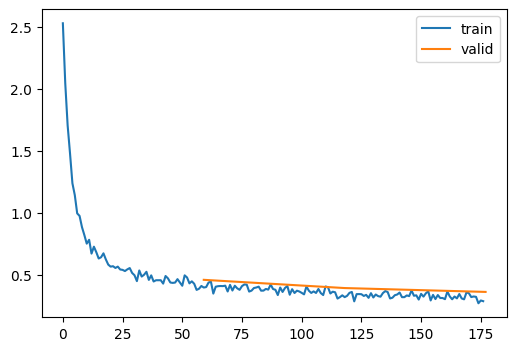

In [20]:
rec = RecorderCB(lr=_lr)
batchSched = BatchSchedCB(scheduler)

model = get_model(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats, batchSched, rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=optim.Adam)
learn.fit(3)

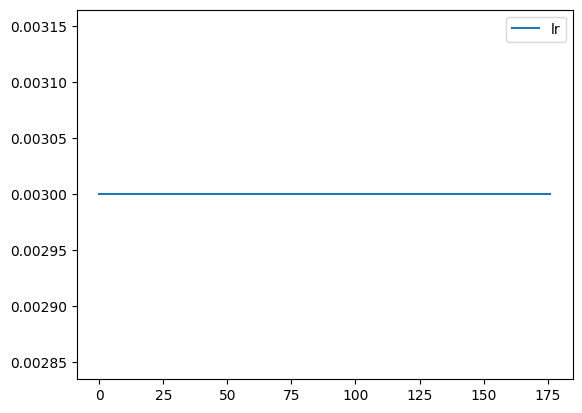

In [21]:
rec.plot()

# Build Custom Scheduler

In [22]:
def getLr(lr_start, steps, i):
    return lr_start/2 * (1 + math.cos(i*math.pi/steps))

steps = 100
init_lr = 0.2
list_lrs = [init_lr]
step = partial(getLr, init_lr, steps)

for i in range(steps):
    list_lrs.append(step(i))    

#plt.plot(list_lrs)

In [29]:
class CosAnnealerScheduler():x
    
    '''
    I should implement sched.state_dict() here
    '''
    
    def __init__(self, optimizer, T_max):
        self.optimizer = optimizer
        self.T_max = T_max
        self.step_couter = 0
        self.last_lr = optimizer.param_groups[0]['lr']
        self.lr_start = optimizer.param_groups[0]['lr']
        
    def get_last_lr(self):
        return self.optimizer.param_groups[0]['lr']   
    
    def step(self):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.lr_start / 2 * (1 + math.cos(self.step_couter * math.pi / self.T_max))
        self.step_couter+=1

In [30]:
# reset optimizer
model = get_model(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=[SingleBatchCB()])
learn.fit(1)
optimizer = learn.opt # fit model for 1 batch s.t. just to get its opt

test = CosAnnealerScheduler(optimizer, 100)
test.get_last_lr()

0.003

last 5 lrs:  [1.8467489107293344e-05, 2.6569123906967087e-05, 3.612485709187885e-05, 4.712525830705322e-05, 5.955947148458524e-05]


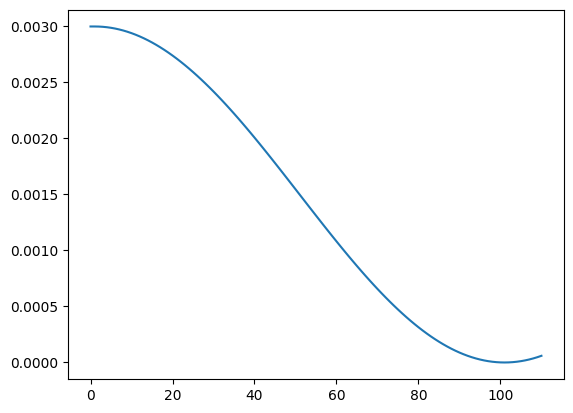

In [31]:
sched_lrs(test, 110) # goes up after 100 steps cuz cosine curve

last 5 lrs:  [1.8467489107293344e-05, 1.1827948028283186e-05, 6.657053095380006e-06, 2.9599073575926615e-06, 7.401594514025999e-07]


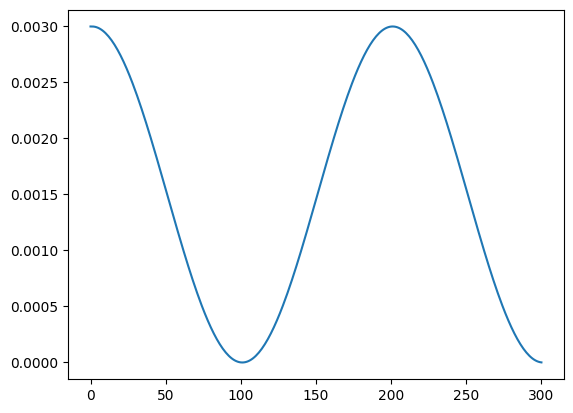

In [32]:
# reset optimizer
model = get_model(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=[SingleBatchCB()])
learn.fit(1)
optimizer = learn.opt # fit model for 1 batch s.t. just to get its opt

test = CosAnnealerScheduler(optimizer, 100)
test.get_last_lr()
sched_lrs(test, 300) # goes up after 100 steps cuz cosine curve

# Test custom scheduler

In [33]:
n_epochs = 3
tmax = n_epochs * len(dls.train)
print(tmax)
scheduler = partial(CosAnnealerScheduler, T_max=tmax)

177


In [34]:
rec = RecorderCB(lr=_lr)
batchSched = BatchSchedCB(scheduler)

model = get_model(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats, batchSched, rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=optim.Adam)
learn.fit(3)

AttributeError: 'CosAnnealerScheduler' object has no attribute 'state_dict'

In [ ]:
rec.plot()

In [ ]:
# reset optimizer
model = get_model(general_leaky_relu, norm=nn.BatchNorm2d).apply(f_init_weights)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=[SingleBatchCB()])
learn.fit(1)
optimizer = learn.opt # fit model for 1 batch s.t. just to get its opt

In [ ]:
print_obj_API(optimizer)

In [ ]:
for g in optimizer.param_groups:
    print(g.keys())

Small discrepancy but i think ok

In [ ]:
l2= [[2.6569123906967083e-05], [3.612485709187885e-05], [4.712525830705322e-05], [5.955947148458523e-05], [7.341522555726953e-05]]

[round(i[0],4) for i in l2]

In [ ]:
l1 = [1.8467489107293344e-05, 2.6569123906967087e-05, 3.612485709187885e-05, 4.712525830705322e-05, 5.955947148458524e-05]
[round(i,4) for i in l1]